# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import numpy as np
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading the Files

Download the csv files into the `data/` directory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

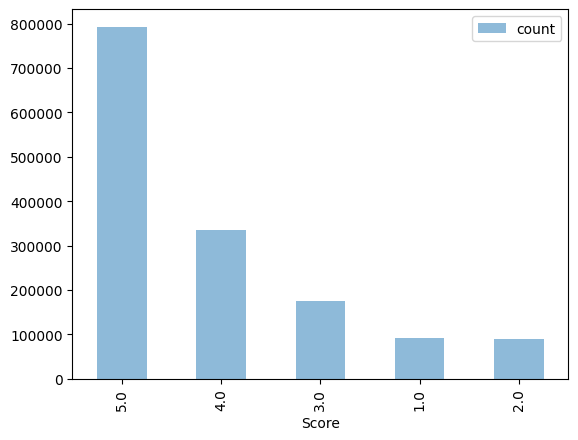


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
# trainingSet = pd.read_csv("./data/train.csv")
# testingSet = pd.read_csv("./data/test.csv")
trainingSet = pd.read_csv('/content/drive/MyDrive/CS506/midterm/data/train.csv')
testingSet = pd.read_csv('/content/drive/MyDrive/CS506/midterm/data/test.csv')

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [4]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['Time'].dt.year

    # label_encoder = LabelEncoder()
    # df['UserId'] = label_encoder.fit_transform(df['UserId'])
    # df['Month'] = df['Time'].dt.month
    # df['Day'] = df['Time'].dt.day
    # df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    # df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    # df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    # df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

    df["Review Length"] = df["Text"].fillna("").apply(len)

    df["User Average Review Score"] = df.groupby('UserId')['Score'].transform('mean')

    sia = SentimentIntensityAnalyzer()
    if exists('/content/drive/MyDrive/CS506/midterm/data/Vader_train_summary.csv'):
      vader_df = pd.read_csv('/content/drive/MyDrive/CS506/midterm/data/Vader_train_summary.csv')
      df[['Vader_neg_summary', 'Vader_pos_summary', 'Vader_compound_summary']] = vader_df[['Vader_neg', 'Vader_pos', 'Vader_compound']]
    else:
      df[['Vader_neg_summary', 'Vader_neu_summary', 'Vader_pos_summary', 'Vader_compound_summary']] = df['Summary'].fillna('').apply(lambda x: pd.Series(sia.polarity_scores(x)))
      df[['Vader_neg_summary', 'Vader_neu_summary', 'Vader_pos_summary', 'Vader_compound_summary']].to_csv("/content/drive/MyDrive/CS506/midterm/data/Vader_train_summary.csv", index=False)

    if exists('/content/drive/MyDrive/CS506/midterm/data/Vader_train_text.csv'):
      vader_df = pd.read_csv('/content/drive/MyDrive/CS506/midterm/data/Vader_train_text.csv')
      df[['Vader_neg_text', 'Vader_pos_text', 'Vader_compound_text']] = vader_df[['Vader_neg_text', 'Vader_pos_text', 'Vader_compound_text']]
    else:
      df[['Vader_neg_text', 'Vader_neu_text', 'Vader_pos_text', 'Vader_compound_text']] = df['Text'].fillna('').apply(lambda x: pd.Series(sia.polarity_scores(x)))
      df[['Vader_neg_text', 'Vader_neu_text', 'Vader_pos_text', 'Vader_compound_text']].to_csv("/content/drive/MyDrive/CS506/midterm/data/Vader_train_text.csv", index=False)


    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['Summary'].fillna(''))
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    tfidf_df.fillna(0, inplace=True)

    svd_model = TruncatedSVD(n_components=250)

    svd_matrix = svd_model.fit_transform(tfidf_df)
    svd_df = pd.DataFrame(svd_matrix, columns=[f'SVD_Component_{i+1}' for i in range(svd_matrix.shape[1])])

    # pca_model = PCA(n_components=0.99)
    # pca_matrix = pca_model.fit_transform(tfidf_df)

    # pca_df = pd.DataFrame(pca_matrix, columns=[f'PCA_{i+1}' for i in range(pca_matrix.shape[1])])

    df_with_vectors = pd.concat([df.reset_index(drop=True), svd_df.reset_index(drop=True)], axis=1)

    return df_with_vectors

# Load the feature extracted files if they've already been generated
# if exists('./data/X_train.csv'):
#     X_train = pd.read_csv("./data/X_train.csv")
# if exists('./data/X_submission.csv'):
#     X_submission = pd.read_csv("./data/X_submission.csv")
if exists('/content/drive/MyDrive/CS506/midterm/data/X_train.csv'):
    X_train = pd.read_csv("/content/drive/MyDrive/CS506/midterm/data/X_train.csv")
if exists('/content/drive/MyDrive/CS506/midterm/data/X_submission.csv'):
    X_submission = pd.read_csv("/content/drive/MyDrive/CS506/midterm/data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    # X_submission.to_csv("./data/X_submission.csv", index=False)
    # X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [5]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [6]:
# features = ['Helpfulness', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Vader_score_summary', 'Vader_score_text']

# X_train_select = X_train[features]
# X_test_select = X_test[features]
# X_submission_select = X_submission[features]
columns_to_drop = ['ProductId', 'Time', 'UserId', 'Summary', 'Text', 'Id', 'HelpfulnessNumerator']
X_train_select = X_train.drop(columns=columns_to_drop)
X_test_select = X_test.drop(columns=columns_to_drop)
X_submission_select = X_submission.drop(columns=(columns_to_drop+['Score']))

# Model Creation

In [7]:
# Learn the model

model = XGBClassifier(tree_method = "hist", device = "cuda", random_state=0).fit(X_train_select, Y_train.astype(int) - 1)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select) + 1

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:01:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy on testing set =  0.6411417153198181


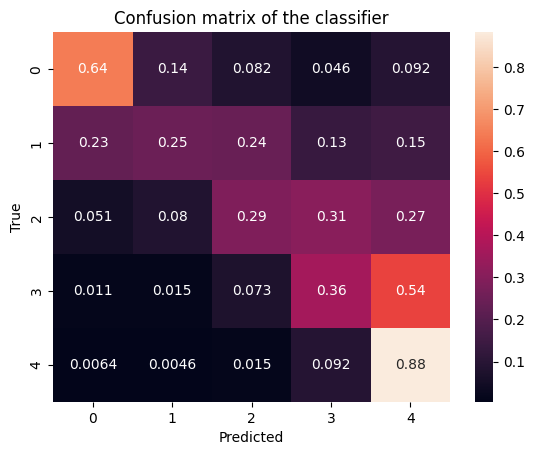

In [8]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [9]:
print("Accuracy on training set = ", accuracy_score(Y_train.astype(int) - 1, model.predict(X_train_select)))

Accuracy on training set =  0.6597304320896226


In [10]:
# Create the submission file
X_submission['Score'] = (model.predict(X_submission_select) + 1).astype('float64')
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)